In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
import glob
from shutil import rmtree

from math import ceil, floor, log
from PIL import Image

train_images_dir = './rsna-intracranial-hemorrhage-detection/stage_2_train/'

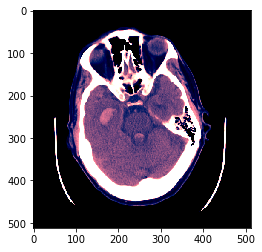

In [2]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# Sanity Check
# Example dicoms: ID_2669954a7, ID_5c8b5d701, ID_52c9913b1

dicom = pydicom.dcmread(train_images_dir + 'ID_0a0f59c95' + '.dcm')
#                                     ID  Label
# 4045566          ID_5c8b5d701_epidural      0
# 4045567  ID_5c8b5d701_intraparenchymal      1
# 4045568  ID_5c8b5d701_intraventricular      0
# 4045569      ID_5c8b5d701_subarachnoid      
# 4045570          ID_5c8b5d701_subdural      1
# 4045571               ID_5c8b5d701_any      1
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);

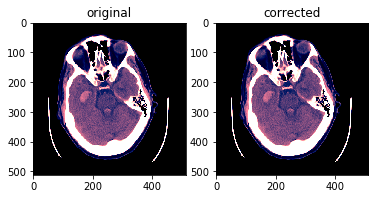

In [3]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def dicom_to_img(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_0a0f59c95" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(dicom_to_img(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(dicom_to_img(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

In [4]:
windowed_dir = './data/windowed/'
windowed_train_dir = os.path.join(windowed_dir, 'train')
windowed_valid_dir = os.path.join(windowed_dir, 'valid')
windowed_test_dir = os.path.join(windowed_dir, 'test')
if os.path.exists(windowed_dir):
    rmtree(windowed_dir)
os.makedirs(windowed_dir)
os.makedirs(windowed_train_dir)
os.makedirs(windowed_valid_dir)
os.makedirs(windowed_test_dir)

In [5]:
import multiprocessing as mp
def f(t):
    dcm_path, windowed_dir = t[0], t[1]
    dcm_name = dcm_path.split('/')[-1]
    dcm = pydicom.dcmread(dcm_path)
    img = 255 * dicom_to_img(dcm, window_with_correction)
    image = Image.fromarray(img.astype('uint8'), 'RGB')
    image.save(os.path.join(windowed_dir, dcm_name.replace('.dcm', '.png')))

In [6]:
%%time

dcm_paths = glob.glob(os.path.join('./data/set/train/*'))
args = list(zip(dcm_paths, len(dcm_paths) * [windowed_train_dir]))
num_processes = mp.cpu_count() - 2 if mp.cpu_count() > 2 else 1 
print('No. processes:', num_processes)
with mp.Pool(num_processes) as p:
    p.map(f, args)

No. processes: 15
CPU times: user 587 ms, sys: 148 ms, total: 735 ms
Wall time: 15min


In [7]:
%%time

dcm_paths = glob.glob(os.path.join('./data/set/valid/*'))
args = list(zip(dcm_paths, len(dcm_paths) * [windowed_valid_dir]))
num_processes = mp.cpu_count() - 2 if mp.cpu_count() > 2 else 1 
print('No. processes:', num_processes)
with mp.Pool(num_processes) as p:
    p.map(f, args)

No. processes: 15
CPU times: user 179 ms, sys: 50.8 ms, total: 230 ms
Wall time: 50.9 s


In [8]:
%%time

dcm_paths = glob.glob(os.path.join('./data/set/test/*'))
args = list(zip(dcm_paths, len(dcm_paths) * [windowed_test_dir]))
num_processes = mp.cpu_count() - 2 if mp.cpu_count() > 2 else 1 
print('No. processes:', num_processes)
with mp.Pool(num_processes) as p:
    p.map(f, args)

No. processes: 15
CPU times: user 149 ms, sys: 66 ms, total: 215 ms
Wall time: 46.5 s


In [9]:
!cp -r ./data/annots/ ./data/windowed/annots/